# Import libraries

In [1]:
# - Import required Python modules
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import csv
import scipy.stats as sps

In [2]:
# - Import our custom code for importing data
import os,sys,inspect
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../code/mapping'))) 

import read_data as rd

# Read income, assets and taxation data

In [3]:
# - Read map and 2015 tax data
gdfMap = rd.read_WV_map()
dfIncome = rd.read_2015_income()
dfAssets = rd.read_2015_assets()

# - Read mappings between IDs and descriptors
(dfMap_WVid_name, dfMapWVid_geoID, dfMapICid, dfMapACid) = rd.read_2015_mappings()

`GeoPandas` is a package for interpreting and manipulating map geometry data, alongside other data about map locations. Here we have a variable `gdfMap`, containing the area boundaries for the Basel-Stadt Wohnviertel (suburbs). The function `rd.read_WV_map()` does all the hard work of locating the files and importing them. We can have a look at the data using the `.head()` method:

In [4]:
gdfMap.head()

,OBJID,OBJECTID,TXT,ZTXT,TYPE,geometry
0,17136,1,7,07,Bruderholz,"POLYGON ((2612555.909 1264547.542, 2612560.552..."
1,17139,2,6,06,Gundeldingen,"POLYGON ((2610887.105 1266551.468, 2610896.202..."
2,17142,3,5,05,St. Alban,"POLYGON ((2612941.971 1267023.045, 2613000.085..."
3,17145,4,4,04,Breite,"POLYGON ((2613683.78 1266891.09, 2613686.423 1..."
4,17148,5,8,08,Bachletten,"POLYGON ((2610560.968 1266791.31, 2610571.054 ..."


Likewise, the functions `rd.read_2015_income()` and `...assets()` import data for income, assets and taxation, broken down by Wohnviertel.

In [5]:
dfIncome.head()

,wohnviertel_id,Wohnviertel,incomeclass_id,Income class,num_declarations,total_income,total_income_tax
0,1,Altstadt Grossbasel,1,0 to 29'999,640,7257907,113268
1,1,Altstadt Grossbasel,2,30'000 to 59'999,271,12238573,1399279
2,1,Altstadt Grossbasel,3,60'000 to 89'999,245,18121653,2831659
3,1,Altstadt Grossbasel,4,90'000 to 119'999,149,15385085,2526420
4,1,Altstadt Grossbasel,5,more than 120'000,370,111343117,21030480


In [6]:
dfAssets.head()

,wohnviertel_id,Wohnviertel,assetclass_id,Asset class,num_declarations,total_assets,total_asset_tax
0,1,Altstadt Grossbasel,1,0 to 49'999,945,11427211,68
1,1,Altstadt Grossbasel,2,50'000 to 99'999,153,10863042,1148
2,1,Altstadt Grossbasel,3,100'000 to 299'999,197,35659740,59634
3,1,Altstadt Grossbasel,4,300'000 to 599'999,132,57970452,182471
4,1,Altstadt Grossbasel,5,more than 700'000,248,1584480288,8993661


These data frames have various IDs (`wohnviertel_id`, `incomeclass_id`, `assetclass_id`) which define enumerations. There are also data in CHF about total income and assests, tax, etc. The variables `dfMap...` specify how to relate various enumerations. Of particular importance is how to map between `wohnviertel_id` and `geo_worhnviertel_id` (which is the `OBJECTID` column in the map data above).

In [7]:
dfMapWVid_geoID.head()

,wohnviertel_id,geo_wohnviertel_id,Wohnviertel
0,1,7,Altstadt Grossbasel
1,2,6,Vorstaedte
2,3,8,Am Ring
3,4,4,Breite
4,5,3,St. Alban


# Combining taxation data and the map
Now that we know how to imoport the data, let's draw a map of income / taxation across Basel Stadt. We first need to compute the total income per Wohnviertel, since this is currently broken down by asset class. We do this by defining some simple index functions, which return the rows of `dfIncome` that correspond to particular Wohnviertel (`WV`) or income class (`IC`).

In [8]:
# - Get unique Wohnviertel IDs
vnWVIDs = pd.unique(dfIncome['wohnviertel_id'])

# - Get total income tax for each wohnviertel
def find_WV(wv_id):
    return dfIncome.wohnviertel_id.map(lambda i: i == wv_id)

def find_IC(ic_id):
    return dfIncome.incomeclass_id.map(lambda i: i == ic_id)

# - Compute totals for income for each WV
vfWVTotalIncome = [sum(dfIncome.loc[find_WV(id), 'total_income'])
                   for id in vnWVIDs]

vnTotalDeclarations = [sum(dfIncome.loc[find_WV(id), 'num_declarations'])
                           for id in vnWVIDs]

Let's plot the total income per Wohnviertel to take a look at it.

Text(0.5,1,'Total income per Wohnviertel')

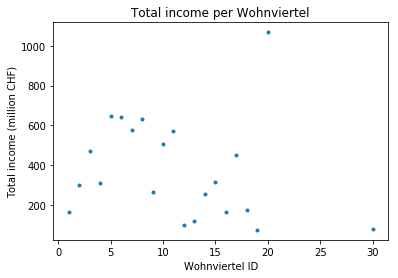

In [9]:
# - Make a plot of total income
plt.figure()
plt.plot(vnWVIDs, np.array(vfWVTotalIncome) / 1e6, '.')
plt.xlabel('Wohnviertel ID')
plt.ylabel('Total income (million CHF)')
plt.title('Total income per Wohnviertel')

Woah, one Wohnviertel has a much higher total income than the others! Let's find out which one that is.

In [10]:
# - Find the WV with largest total income
nRichestWV = np.argmax(vfWVTotalIncome)

# - Map that to WV id
nRichestWVID = vnWVIDs[nRichestWV]

# - Find the name of that WV
dfMap_WVid_name[dfMap_WVid_name['wohnviertel_id'] == nRichestWVID]

,wohnviertel_id,wohnviertel_str
19,20,Riehen


Now lets map total income across Basel Stadt. `geopandas` data frames are smart, and know how to generate maps directly. First we need to combine the map data with the total income data we just calculated.

In [11]:
# - Make a new data frame containing income per WV
dfTotalIncome = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                              'total_income': np.asarray(vfWVTotalIncome) / 1e6})

# - Use the Map variable to relate WV id to geo WV id
dfTotalIncome = pd.merge(dfTotalIncome, dfMapWVid_geoID,
                         on = 'wohnviertel_id')

# - Merge this with the map data
gdfMap_BS_Income = pd.merge(gdfMap, dfTotalIncome, 
                            left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

Now we can produce a map using the `.plot()` method.

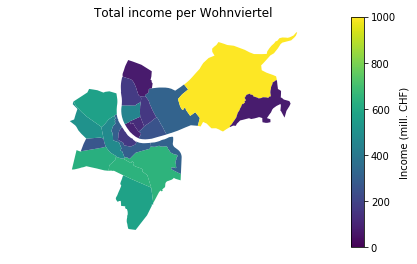

In [12]:
ax = gdfMap_BS_Income.plot(column = 'total_income', vmin = 0, vmax = 1000)
plt.title('Total income per Wohnviertel')
plt.axis('off')

# - Add a colour bar so the map is interpretable
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1000))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Income (mill. CHF)')


How about income *tax* per wohnviertel?

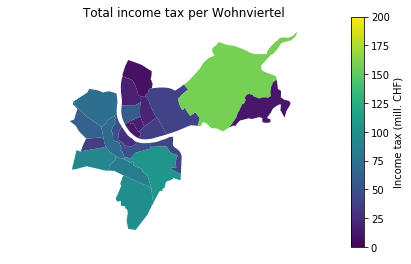

In [13]:
# - Compute totals for income tax for each WV and plot 
vfWVTotalIncomeTax = [sum(dfIncome.loc[find_WV(id), 'total_income_tax'])
                      for id in vnWVIDs]

# - Make a new data frame containing income taxper WV
dfTotalIncomeTax = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                                 'total_income_tax': np.asarray(vfWVTotalIncomeTax) / 1e6})

# - Use the Map variable to relate WV id to geo WV id
dfTotalIncomeTax = pd.merge(dfTotalIncomeTax, dfMapWVid_geoID,
                            on = 'wohnviertel_id')

# - Merge this with the map data
gdfMap_BS_IncomeTax = pd.merge(gdfMap, dfTotalIncomeTax, 
                               left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

# - Plot the map
ax = gdfMap_BS_IncomeTax.plot(column = 'total_income_tax', vmin = 0, vmax = 200)
plt.title('Total income tax per Wohnviertel')
plt.axis('off')

# - Add a colour bar so the map is interpretable
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=200))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
cb = fig.colorbar(sm, cax=cax)
cb.set_label('Income tax (mill. CHF)')


,OBJID,OBJECTID,TXT,ZTXT,TYPE,geometry,total_income_tax,wohnviertel_id,geo_wohnviertel_id,Wohnviertel
0,17136,1,7,07,Bruderholz,"POLYGON ((2612555.909 1264547.542, 2612560.552...",98.192822,7,1,Bruderholz
1,17139,2,6,06,Gundeldingen,"POLYGON ((2610887.105 1266551.468, 2610896.202...",83.517575,6,2,Gundeldingen
2,17142,3,5,05,St. Alban,"POLYGON ((2612941.971 1267023.045, 2613000.085...",104.234098,5,3,St. Alban
3,17145,4,4,04,Breite,"POLYGON ((2613683.78 1266891.09, 2613686.423 1...",40.062655,4,4,Breite
4,17148,5,8,08,Bachletten,"POLYGON ((2610560.968 1266791.31, 2610571.054 ...",92.431802,8,5,Bachletten
5,17151,6,2,02,Vorstädte,"POLYGON ((2610927.89 1268322.563, 2610934.264 ...",49.197631,2,6,Vorstaedte
6,17154,7,1,01,Altstadt Grossbasel,"POLYGON ((2611365.755 1267577.786, 2611374.934...",27.901106,1,7,Altstadt Grossbasel
7,17157,8,3,03,Am Ring,"POLYGON ((2610705.095 1267923.464, 2610679.814...",70.596565,3,8,Am Ring
8,17160,9,9,09,Gotthelf,"POLYGON ((2609244.573 1266802.241, 2609236.385...",36.241772,9,9,Gotthelf
9,17163,10,10,10,Iselin,"POLYGON ((2610233.635 1267655.846, 2610283.869...",61.515633,10,10,Iselin


# Breaking down income classes
It might be interesting to explore how the proportion of income tax breaks down per income bracket. Let's look at the proportion of income taxt paid by the lowest vs highest income bracket, per WV. We need to index the income data frame to locate income classes 1 (lowest) and 5 (highest) for each WV.

In [14]:
# - Define a function that locates 
def find_WV_IC(wv_id, ic_id):
    return find_WV(wv_id) & find_IC(ic_id)

# - Get percentage of total income tax for lowest income bracket
vfPrcIncomeTaxLowestBracket = [
    np.asscalar(dfIncome.loc[find_WV_IC(wv, 1), 'total_income_tax'] / tot) \
    for wv, tot in zip(vnWVIDs, vfWVTotalIncomeTax)
    ]

# - Get percentage of total income tax for highest income bracket
vfPrcIncomeTaxHighestBracket = [
    np.asscalar(dfIncome.loc[find_WV_IC(wv, 5), 'total_income_tax'] / tot) \
    for wv, tot in zip(vnWVIDs, vfWVTotalIncomeTax)
    ]

# - Get total number of declarations per bracket
vnNumDeclarationsBrackets = [
    np.sum(dfIncome.loc[find_IC(ic), 'num_declarations']) for ic in range(1, 6)
    ]

In [15]:
# - Construct data frames for tax proportions
dfPrcIncomeTax = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                               'prop_inc_tax_lowest': np.asarray(vfPrcIncomeTaxLowestBracket) * 100,
                               'prop_inc_tax_highest': np.asarray(vfPrcIncomeTaxHighestBracket) * 100})

dfPrcIncomeTax = pd.merge(dfPrcIncomeTax, dfMapWVid_geoID,
                          on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapTax = pd.merge(gdfMap, dfPrcIncomeTax,
                     left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

In [77]:
dfIncome['income_per_capita'] = dfIncome['total_income']/dfIncome['num_declarations'] 

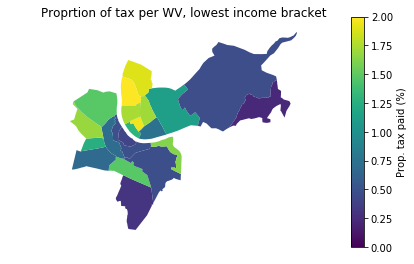

In [16]:
# - Plot maps of proportion of income tax paid by respective brackets
ax = gdfMapTax.plot(column = 'prop_inc_tax_lowest', vmin = 0, vmax = 2)
plt.axis('off')
plt.title('Proprtion of tax per WV, lowest income bracket')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=2))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Prop. tax paid (%)')


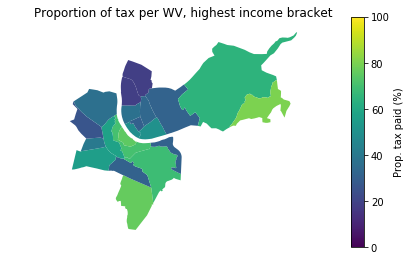

In [17]:
# - Plot maps of proportion of income tax paid by respective brackets
ax = gdfMapTax.plot(column = 'prop_inc_tax_highest', vmin = 0, vmax = 100)
plt.axis('off')
plt.title('Proportion of tax per WV, highest income bracket')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=100))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Prop. tax paid (%)')


# Equality metrics
One very common metric for quantifying inequality in an income distribution is called the *Gini* coefficient. From [wikipedia](https://en.wikipedia.org/wiki/Gini_coefficient#Discrete_probability_distribution):

For a discrete probability distribution with probability mass function $f(y_i)$, $i = 1 \textrm{ to } n$, where $f(y_i)$ is the fraction of the population with income or wealth $y_i >0$, the Gini coefficient is:
$$G={\frac {1}{2\mu }}\sum \limits _{i=1}^{n}\sum \limits _{j=1}^{n}\,f(y_{i})f(y_{j})|y_{i}-y_{j}|$$
where
$$\mu =\sum \limits _{i=1}^{n}y_{i}f(y_{i})$$

If the points with nonzero probabilities are indexed in increasing order ($y_i < y_{i+1}$) then:

$$G=1-{\frac {\Sigma _{i=1}^{n}\;f(y_{i})(S_{i-1}+S_{i})}{S_{n}}}$$
where
$S_{i}=\Sigma _{j=1}^{i}\;f(y_{j})\,y_{j}\,$ and $S_{0}=0\,$. These formulae are also applicable in the limit as $n\rightarrow \infty$.

Let's define a function `gini()`, which takes a list of population sizes in income classes, along with the minimum bound of each income class, and returns the *Gini* coefficient.

In [18]:
# - Define a function that calculates the Gini coefficient for a discrete distribution
def gini(vnPopClasses, vfClassTotalIncome):
    vfF_yi = np.array(vnPopClasses) / np.sum(vnPopClasses)
    vfyi = np.array(vfClassTotalIncome)
    vfSi = np.cumsum(vfyi * vfF_yi)
    
    fGini = 1-np.sum(vfF_yi[1:] * (vfSi[:-1] + vfSi[1:]) / vfSi[-1])
    
    return fGini

For a maximally equal distribution of incomes (or whatever measure), the Gini will be close to zero. For a maximally unequal distribution (one persion with all the wealth), the Gini will be close to one.

In [19]:
# - Equal distribution
print('Equal distribution: ', gini(np.ones(100), np.ones(100)))

# - Unequal distribution
print('Unequal distribution: ', gini(np.ones(100), np.concatenate(([0] * 99, [1]))))

Equal distribution:  0.00010000000000010001
Unequal distribution:  0.99


Now lets compute the Gini for income, assets, income tax.

In [81]:
vnWVIDs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 30])

In [96]:
# - Compute Gini for each Wohnviertel income distribution
vfGini_Income = [gini(dfIncome.loc[find_WV(nWV), 'num_declarations'], dfIncome.loc[find_WV(nWV), 'total_income']) for nWV in vnWVIDs]
vfGini_Assets = [gini(dfAssets.loc[find_WV(nWV), 'num_declarations'], dfAssets.loc[find_WV(nWV), 'total_assets']) for nWV in vnWVIDs]
vfGini_IncomeTax = [gini(dfIncome.loc[find_WV(nWV), 'num_declarations'], dfIncome.loc[find_WV(nWV), 'total_income_tax']) for nWV in vnWVIDs]
vfGini_AssetTax = [gini(dfAssets.loc[find_WV(nWV), 'num_declarations'], dfAssets.loc[find_WV(nWV), 'total_asset_tax']) for nWV in vnWVIDs]


In [107]:
aftotalDeclaNum = np.array([np.sum(dfAssets.loc[find_WV(nWV), 'num_declarations']) for nWV in vnWVIDs])
aftotalIncome = np.array([np.sum(dfIncome.loc[find_WV(nWV), 'total_income']) for nWV in vnWVIDs])
aftotalAssets = np.array([np.sum(dfAssets.loc[find_WV(nWV), 'total_assets']) for nWV in vnWVIDs])
aftotalIncomeTax = np.array([np.sum(dfIncome.loc[find_WV(nWV), 'total_income_tax']) for nWV in vnWVIDs])
aftotalAssetTax = np.array([np.sum(dfAssets.loc[find_WV(nWV), 'total_asset_tax']) for nWV in vnWVIDs])
a_income_per_capita = aftotalIncome / aftotalDeclaNum
a_assets_per_capita = aftotalAssets / aftotalDeclaNum
a_incomeTax_per_capita = aftotalIncomeTax / aftotalDeclaNum
a_totalAssetTax_per_capita = aftotalAssetTax / aftotalDeclaNum


In [109]:
# - Map gini for income and assets

# - Construct data frames for income Gini
dfGini = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                       'gini_income': np.asarray(vfGini_Income),
                       'gini_assets': np.asarray(vfGini_Assets),
                       'gini_income_tax': np.asarray(vfGini_IncomeTax),
                       'gini_asset_tax': np.asarray(vfGini_AssetTax),
                       'income_per_capita':a_income_per_capita,
                       'assets_per_capita':a_assets_per_capita,
                       'incomeTax_per_capita':a_incomeTax_per_capita,
                       'totalAssetTax_per_capita':a_totalAssetTax_per_capita
                      })


dfGini = pd.merge(dfGini, dfMapWVid_geoID,
                  on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapGini = pd.merge(gdfMap, dfGini,
                      left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

In [119]:
df_Gini_tax_assets_WV = dfGini[['gini_income','gini_assets','gini_income_tax','gini_asset_tax','income_per_capita',
                              'assets_per_capita','incomeTax_per_capita','totalAssetTax_per_capita']]
df_Gini_tax_assets_WV_red = dfGini[['gini_income','gini_income_tax','income_per_capita','incomeTax_per_capita']]

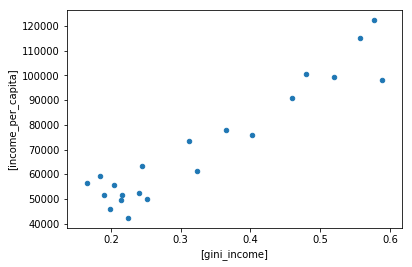

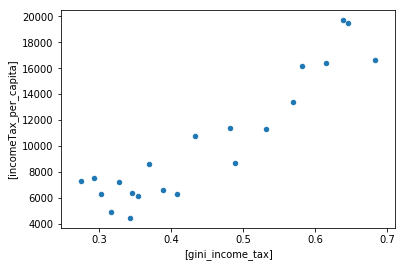

In [133]:
df_Gini_tax_assets_WV.plot.scatter(x=['gini_income'],y=['income_per_capita'])
df_Gini_tax_assets_WV.plot.scatter(x=['gini_income_tax'],y=['incomeTax_per_capita'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf80df7da0>,
      dtype=object)

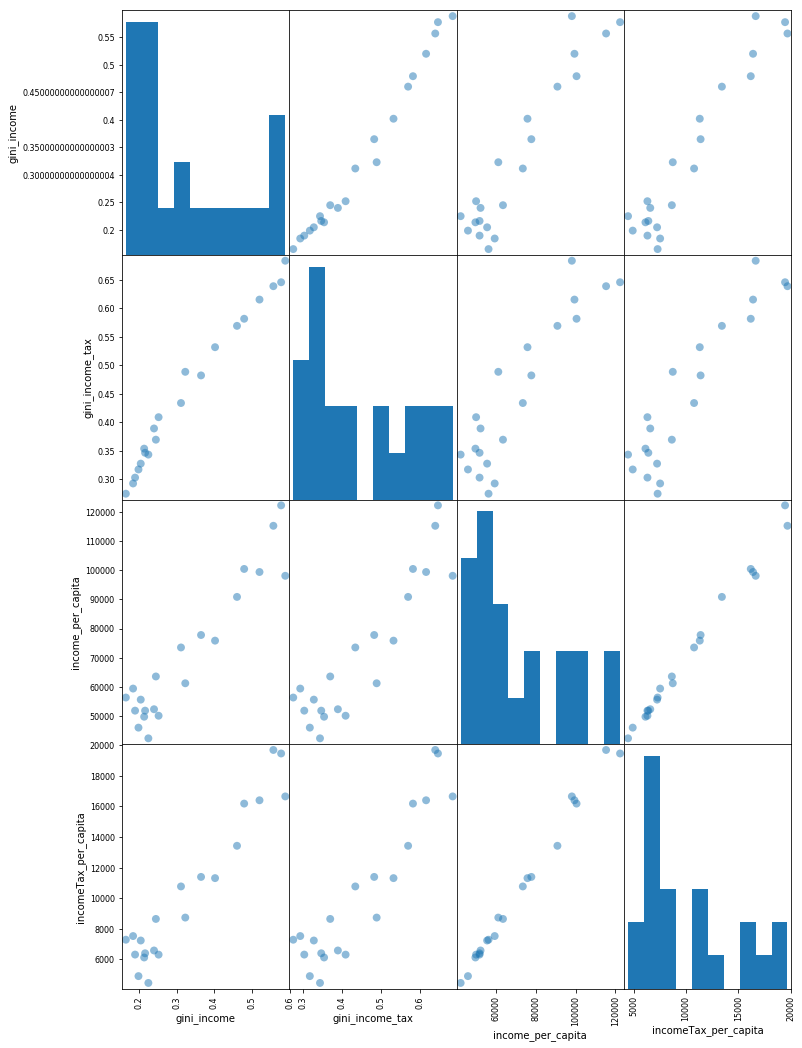

In [134]:
pd.plotting.scatter_matrix(df_Gini_tax_assets_WV[['gini_income','gini_income_tax','income_per_capita','incomeTax_per_capita']],
                          figsize=(12,18), s=250)

### ax = gdfMapGini.plot(column = 'gini_income', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (income)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

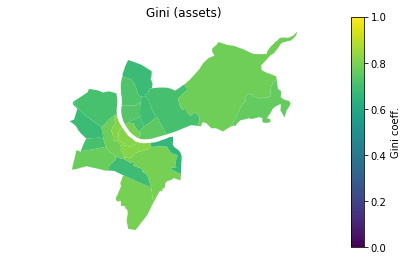

In [24]:
ax = gdfMapGini.plot(column = 'gini_assets', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (assets)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

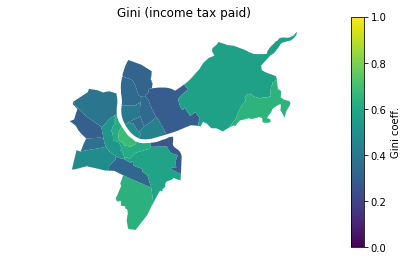

In [25]:
ax = gdfMapGini.plot(column = 'gini_income_tax', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (income tax paid)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

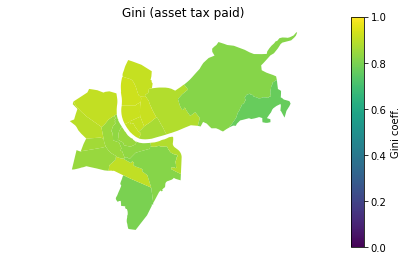

In [26]:
ax = gdfMapGini.plot(column = 'gini_asset_tax', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (asset tax paid)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

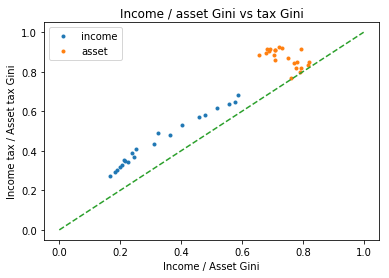

In [27]:
plt.figure()
plt.plot(vfGini_Income, vfGini_IncomeTax, '.')
plt.plot(vfGini_Assets, vfGini_AssetTax, '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Income / Asset Gini')
plt.ylabel('Income tax / Asset tax Gini')
plt.legend(['income', 'asset'])
plt.title('Income / asset Gini vs tax Gini');

# Read quintile income and asset taxation data
Also available are the income, asset and taxation data split by population quintiles calculated for each WV. This samples the households in the WV more evenly, rather than applying the same income / asset brackets across all WVs.

In [28]:
# - Read map and 2015 tax data in quintiles
gdfMap = rd.read_WV_map()
dfIncomeQ = rd.read_2015_income_quintiles()
dfAssetsQ = rd.read_2015_assets_quintiles()

# - Read mappings between IDs and descriptors
(dfMap_WVid_name, dfMapWVid_geoID, dfMapICid, dfMapACid) = rd.read_2015_mappings()

In [29]:
# - Look at the head of the quintile table
dfIncomeQ.head()

,wohnviertel_id,Wohnviertel,incomequintile_id,num_declarations,total_income,total_income_tax,marginal_tax_rate
0,1,Altstadt Grossbasel,1,335,1330220,200,0.000150
1,1,Altstadt Grossbasel,2,335,6878185,184671,0.026849
2,1,Altstadt Grossbasel,3,335,17391161,2233910,0.128451
3,1,Altstadt Grossbasel,4,335,31771183,5158796,0.162373
4,1,Altstadt Grossbasel,5,335,106975586,20323529,0.189983


In [30]:
# - Function to extract WVs from quintile data
def find_WVQ(wv_id):
    return dfIncomeQ.wohnviertel_id.map(lambda i: i == wv_id)

Now we'd like to check whether the GINI values we obtained from the bracket data are similar to those calculated from the quintile data. As the number of brackets / percentiles increases, they should converge to the same number.

In [31]:
# - Compare GINI calculations between Quintile and bracket data
print(
    gini(dfIncomeQ.loc[find_WVQ(1), 'num_declarations'], dfIncomeQ.loc[find_WVQ(1), 'total_income']),
    gini(dfIncome.loc[find_WV(1), 'num_declarations'], dfIncome.loc[find_WV(1), 'total_income'])
)

0.5764627242828384 0.5881204338124254


In [32]:
# - Compute Gini for each Wohnviertel income distribution
vfGini_Income = [gini(dfIncomeQ.loc[find_WVQ(nWV), 'num_declarations'], dfIncomeQ.loc[find_WVQ(nWV), 'total_income']) for nWV in vnWVIDs]
vfGini_Assets = [gini(dfAssetsQ.loc[find_WVQ(nWV), 'num_declarations'], dfAssetsQ.loc[find_WVQ(nWV), 'total_assets']) for nWV in vnWVIDs]
vfGini_IncomeTax = [gini(dfIncomeQ.loc[find_WVQ(nWV), 'num_declarations'], dfIncomeQ.loc[find_WVQ(nWV), 'total_income_tax']) for nWV in vnWVIDs]
vfGini_AssetTax = [gini(dfAssetsQ.loc[find_WVQ(nWV), 'num_declarations'], dfAssetsQ.loc[find_WVQ(nWV), 'total_asset_tax']) for nWV in vnWVIDs]

## Compare GINI computed from quintiles to Stats Amt calculation
The Stats Amt also provides calculations of GINI over income and assets. Let's compare their numbers with ours.

In [33]:
(dfGiniIncome, dfGiniAssets) = rd.read_2015_gini()
dfGiniIncome.head()

,Wohnviertel,wohnviertel_id,gini
0,Altstadt Grossbasel,1,0.637
1,Vorstaedte,2,0.580
2,Am Ring,3,0.521
3,Breite,4,0.415
4,St. Alban,5,0.558


In [34]:
def find_GiniWV(wv_id):
    return dfGiniIncome.wohnviertel_id.map(lambda i: i == wv_id)

vfGini_Income_BS = np.array([dfGiniIncome.loc[find_GiniWV(nWV), 'gini'].get_values() for nWV in vnWVIDs]).flatten()
vfGini_Assets_BS = np.array([dfGiniAssets.loc[find_GiniWV(nWV), 'gini'].get_values() for nWV in vnWVIDs]).flatten()

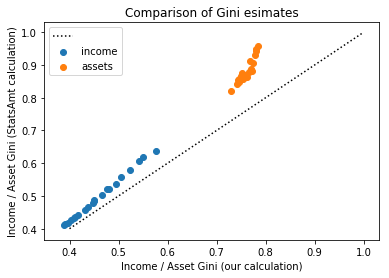

In [35]:
# - Make a comparison plot 
plt.figure()
plt.scatter(np.asarray(vfGini_Income), np.asarray(vfGini_Income_BS))
plt.scatter(np.asarray(vfGini_Assets), np.asarray(vfGini_Assets_BS))
plt.plot([.4, 1], [.4, 1], 'k:')
plt.xlabel('Income / Asset Gini (our calculation)')
plt.ylabel('Income / Asset Gini (StatsAmt calculation)')
plt.legend(['', 'income', 'assets'])
plt.title('Comparison of Gini esimates');

Ideally all points would lie on the diagonal, but with more fine-grained data the numbers from the Stats Amt are probably more accurate. In any case our numbers correspond fairly well with theirs.

## Map GINI across Wohnviertels

In [36]:
# - Map gini for income and assets

# - Construct data frames for income Gini
dfGini = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                       'gini_income': np.asarray(vfGini_Income),
                       'gini_assets': np.asarray(vfGini_Assets),
                       'gini_income_tax': np.asarray(vfGini_IncomeTax),
                       'gini_asset_tax': np.asarray(vfGini_AssetTax)
                      })

dfGini = pd.merge(dfGini, dfMapWVid_geoID,
                  on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapGini = pd.merge(gdfMap, dfGini,
                      left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

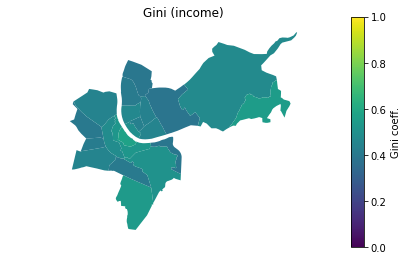

In [37]:
ax = gdfMapGini.plot(column = 'gini_income', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (income)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

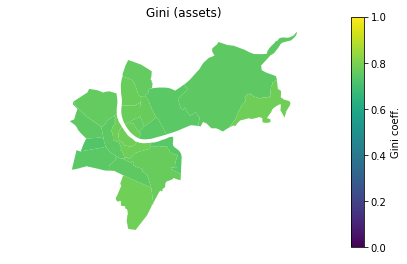

In [38]:
ax = gdfMapGini.plot(column = 'gini_assets', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (assets)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

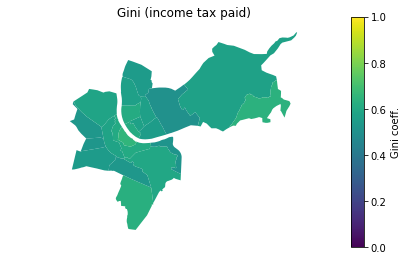

In [39]:
ax = gdfMapGini.plot(column = 'gini_income_tax', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (income tax paid)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

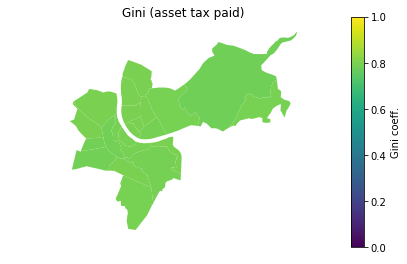

In [40]:
ax = gdfMapGini.plot(column = 'gini_asset_tax', vmin = 0, vmax = 1)
plt.axis('off')
plt.title('Gini (asset tax paid)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

## Compare income and asset vs income/asset tax gini
How equitable, progressive or regressive is the BS taxation system?
* "Equitable" in this case implies that people pay tax strictly as a proportion of their income or assets. In this case, income Gini would be identical to income *tax* Gini
* "Progressive" would imply that poor people pay relatively less tax than rich people as a percentage of their income
* "Regressive" would imply that poor people pay relatively more tax than rich people

We define an income *tax* Gini and asset *tax* Gini metric, computed the same way as for simple income and asset quintiles.

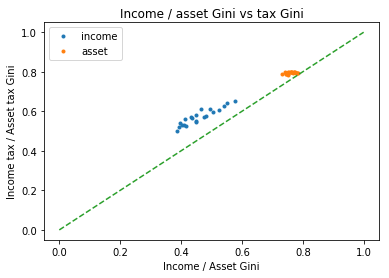

In [41]:
# - Make a figure comparing income and tax Gini

plt.figure()
plt.plot(vfGini_Income, vfGini_IncomeTax, '.')
plt.plot(vfGini_Assets, vfGini_AssetTax, '.')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Income / Asset Gini')
plt.ylabel('Income tax / Asset tax Gini')
plt.legend(['income', 'asset'])
plt.title('Income / asset Gini vs tax Gini');

All points fall above the diagonal, implying Gini for taxation is always higher than Gini for simple income or assets. This suggests that rich people pay a larger proportion of tax, compared with their share of overall income or assets. The taxation system for Basel Stadt is therefore progressive.

*Note*: This analysis only takes into account tax paid as income or asset tax, and ignores sales taxes. Sales taxes, as a fixed proportion of spending, tend to be regressive.

## "Scissor plots" to compare distributions across WVs
Here we define a "scissor plot", inspired by the visualisation made by YAAY: https://www.behance.net/gallery/23151677/Data-Visualization-on-Inequality-of-Society

In these plots, a scissor is drawn with the points touching the average incomes from top and bottom quintiles, with the hinge in the midpoint between these two. The averages for the other quintiles are marked on the lines as coloured dots, and the overall mean income is also marked.

In [42]:
# - Make a scissor plotting function 
def scissor_plot(vfMetricRange, fMidpoint, fMetricMean, vfMetricDots, fXLoc, fWidth):
    # - Plot the scissor lines (min, median, max)
    vfPoints = [vfMetricRange[0], fMidpoint, vfMetricRange[1]]
    plt.plot([fXLoc + fWidth, fXLoc, fXLoc + fWidth], vfPoints, 'k-')
    
    def DotXLoc(fDot):
        if fDot > fMidpoint:
            fDotXLoc = fWidth / (vfMetricRange[1] - fMidpoint) * (fDot - fMidpoint) + fXLoc
        else:
            fDotXLoc = fWidth / (fMidpoint - vfMetricRange[0]) * (fMidpoint - fDot) + fXLoc
        return fDotXLoc
    
    # - Plot the list of dots
    if np.size(vfMetricDots) == 1:
        vfMetricDots = [vfMetricDots]
        
    for fDot in list(vfMetricDots):
        plt.plot(DotXLoc(fDot), fDot, '.', markersize=14)
        
    # - Plot the mean dot
    return plt.plot(DotXLoc(fMetricMean), fMetricMean, 'k.', markersize=12)
    
def plotScissorWVIncome(nWV, fXLoc):
    vfQuintiles = np.array(dfIncomeQ.loc[find_WVQ(nWV), 'total_income'])
    vnNumDeclarations = np.array(dfIncomeQ.loc[find_WVQ(nWV), 'num_declarations'])
    vfRange = vfQuintiles[np.array([0, -1])] / vnNumDeclarations[np.array([0, -1])]

    return scissor_plot(vfRange / 1e3,
                        np.mean(vfRange) / 1e3,
                        np.sum(vfQuintiles) / np.sum(vnNumDeclarations) / 1e3,
                        vfQuintiles / vnNumDeclarations / 1e3,
                        fXLoc,
                        1,
                       )

def plotScissorWVAssets(nWV, fXLoc):
    vfQuintiles = np.array(dfAssetsQ.loc[find_WVQ(nWV), 'total_assets'])
    vnNumDeclarations = np.array(dfAssetsQ.loc[find_WVQ(nWV), 'num_declarations'])
    vfRange = vfQuintiles[np.array([0, -1])] / vnNumDeclarations[np.array([0, -1])]

    return scissor_plot(vfRange / 1e3,
                        np.mean(vfRange) / 1e3,
                        np.sum(vfQuintiles) / np.sum(vnNumDeclarations) / 1e3,
                        vfQuintiles / vnNumDeclarations / 1e3,
                        fXLoc,
                        1,
                       )

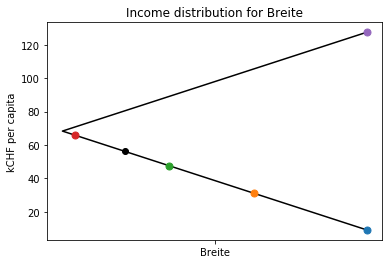

In [43]:
# - Make a scissor plot of a single Wohnviertel 
fig = plt.figure()
plotScissorWVIncome(4, 1)
plt.ylabel('kCHF per capita')
plt.title('Income distribution for Breite')
plt.xticks([1.5], ['Breite']);

Yearly per-capia income for Breite ranges from around 10kCHF per capita to around 130kCHF per capita at the top end. This is moderately unequally distributed — the higest-earning quintile earn more than double on average than the next quintile down.

Let's compare income between two Wohnviertels: Breite and Bettingen.

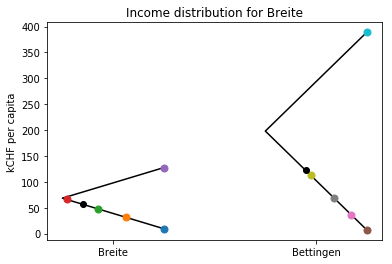

In [44]:
# - Make a scissor plot of a two Wohnviertels 
fig = plt.figure()
plotScissorWVIncome(4, 1)
plotScissorWVIncome(30, 3)
plt.ylabel('kCHF per capita')
plt.title('Income distribution for Breite')
plt.xticks([1.5, 3.5], ['Breite', 'Bettingen']);

People at the top end in Bettingen (the highest quintile) earn more than double than the richest people in Breite, on average. Also, most people in Bettingen (1st to 3rd quintiles) earn less than the average income in Bettingen (black dot). This is because the income distribution is highly skewed.

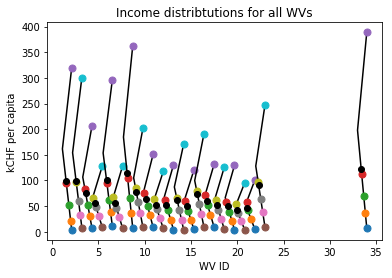

In [45]:
# - Make a scissor plot comparing all Wohnviertels
plt.figure()
for nWV in vnWVIDs:
    plotScissorWVIncome(nWV, nWV*1.1)
    
plt.title('Income distribtutions for all WVs')
plt.xlabel('WV ID')
plt.ylabel('kCHF per capita');

What about income versus assets? How do those distributions compare? Let's examine Breite again.

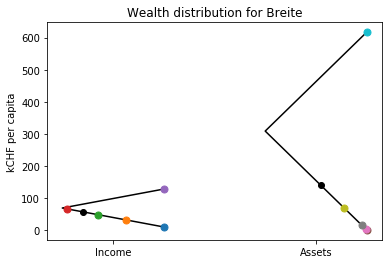

In [46]:
# - Make a scissor plot of a income versus assets for Breite 
fig = plt.figure()
plotScissorWVIncome(4, 1)
plotScissorWVAssets(4, 3)
plt.ylabel('kCHF per capita')
plt.title('Wealth distribution for Breite')
plt.xticks([1.5, 3.5], ['Income', 'Assets']);

Asset distribution is much more unequal than income distribution, in Breite. This is also reflected in the Gini values for income and assets in Breite:

In [47]:
dfGini = dfGiniIncome.join(dfGiniAssets,
                           on = 'wohnviertel_id',
                           lsuffix = '_income',
                           rsuffix = '_assets',
                          )[['Wohnviertel_income',
                             'wohnviertel_id',
                             'gini_income',
                             'gini_assets',
                            ]]
dfGini.loc[3:3]

,Wohnviertel_income,wohnviertel_id,gini_income,gini_assets
3,Breite,4,0.415,0.911


## Load extra datasets to correlate against GINI

In [48]:
# - Read and process ancillary data
def load_sort_dataset(strDataset, strVarName = None):
    if strVarName is None:
        strVarName = strDataset
        
    dfData = rd.read_ancillary_data(strDataset)
    dfData = dfData.sort_values('wohnviertel_id')
    return np.asarray(dfData[strVarName])

vfPropGreenArea = load_sort_dataset('PropGreenArea')
vfPropWomenAtWork = load_sort_dataset('PropWomenAtWork')
vfPropSwiss = load_sort_dataset('PropSwiss')
vfPropApartments = load_sort_dataset('Prop1-2RoomApartments', 'PropApartments')
vnNumRobberies = load_sort_dataset('NumRobberies')
vnNumRobberies[np.isnan(vnNumRobberies)] = 0
vfNumDogsPer100 = load_sort_dataset('NumDogsPer100', 'NumDogs')
vfPopPerHectare = load_sort_dataset('PopPerHectare', 'PopPerHect')
vfTotalIncome = np.asarray(dfTotalIncome['total_income'])

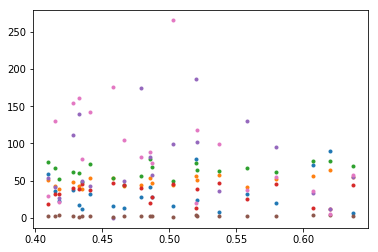

In [49]:
# plt.axis((0, 1, 0, 100))
plt.figure()
plt.plot(vfGini_Income_BS, vfPropGreenArea, '.')
plt.plot(vfGini_Income_BS, vfPropWomenAtWork, '.')
plt.plot(vfGini_Income_BS, vfPropSwiss, '.')
plt.plot(vfGini_Income_BS, vfPropApartments, '.')
plt.plot(vfGini_Income_BS, vnNumRobberies, '.')
plt.plot(vfGini_Income_BS, vfNumDogsPer100, '.')
plt.plot(vfGini_Income_BS, vfPopPerHectare, '.')

# print(np.corrcoef(vfGini_Income, vfPropGreenArea)[0][1],
#     np.corrcoef(vfGini_Income, vfPropWomenAtWork)[0][1],
#     np.corrcoef(vfGini_Income, vfPropSwiss)[0][1],
#     np.corrcoef(vfGini_Income, vfPropApartments)[0][1],
#     np.corrcoef(vfGini_Income, vnNumRobberies)[0][1],
#     np.corrcoef(vfGini_Income, vfNumDogsPer100)[0][1],
#     np.corrcoef(vfGini_Income, vfPopPerHectare)[0][1])

# print(np.corrcoef(vfTotalIncome, vfPropGreenArea)[0][1],
#     np.corrcoef(vfTotalIncome, vfPropWomenAtWork)[0][1],
#     np.corrcoef(vfTotalIncome, vfPropSwiss)[0][1],
#     np.corrcoef(vfTotalIncome, vfPropApartments)[0][1],
#     np.corrcoef(vfTotalIncome, vnNumRobberies)[0][1],
#     np.corrcoef(vfTotalIncome, vfNumDogsPer100)[0][1],
#     np.corrcoef(vfTotalIncome, vfPopPerHectare)[0][1])

# print(np.corrcoef(vfPropWomenAtWork, vfPropGreenArea)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPropWomenAtWork)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPropSwiss)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPropApartments)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vnNumRobberies)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfNumDogsPer100)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPopPerHectare)[0][1])

# print(np.corrcoef(vfPropWomenAtWork, vfPropGreenArea)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPropWomenAtWork)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPropSwiss)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPropApartments)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vnNumRobberies)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfNumDogsPer100)[0][1],
#     np.corrcoef(vfPropWomenAtWork, vfPopPerHectare)[0][1])


## Produce correlation matrices to examine relationships between GINI and other metrics

In [50]:
# - Build a magtrix of metrics
mfMatrix = np.stack((vfGini_Income_BS,
                     vfGini_Assets_BS,
                     vfTotalIncome / np.asarray(vnTotalDeclarations),
                     vfPropGreenArea,
                     vfPropWomenAtWork,
                     vfPropSwiss,
                     vfPropApartments,
                     vnNumRobberies,
                     vfNumDogsPer100,
                     vfPopPerHectare),)

# - List of metric names
vstrIndicators = np.asarray(['GINI_Income',
                             'GINI_Assets',
                  'Income per cap',
                  'Prop Green Area',
                  'Prop Women at work',
                  'Prop Swiss',
                  'Prop small apartments',
                  'Num robberies',
                  'Dogs per cap',
                  'Pop per hect'
                 ])

# - Compute the correlation matrix
mfCorr = np.corrcoef(mfMatrix)
# plt.imshow(mfCorr)

# - Remove lower triangular portion
mfCorr[np.tril_indices(mfCorr.shape[0])] = 0

# - Sort by correlation coefficients
vnTriUInds = np.triu_indices(mfCorr.shape[0], 1)
vfCorrs = mfCorr[vnTriUInds]
vnSortedIndices = np.argsort(vfCorrs)

# - Display a list of strongest effects
list(zip(vfCorrs[vnSortedIndices],
         vstrIndicators[vnTriUInds[0][vnSortedIndices]],
         vstrIndicators[vnTriUInds[1][vnSortedIndices]]))

[(-0.9085169752865186, 'Prop Green Area', 'Prop small apartments'),
 (-0.8094470624521711, 'Prop small apartments', 'Dogs per cap'),
 (-0.7727044190931351, 'Dogs per cap', 'Pop per hect'),
 (-0.7542769225524181, 'Prop Swiss', 'Prop small apartments'),
 (-0.5893102769108419, 'Income per cap', 'Prop small apartments'),
 (-0.5761096343610519, 'Income per cap', 'Pop per hect'),
 (-0.507396600714609, 'Prop Green Area', 'Pop per hect'),
 (-0.45564665188572795, 'Prop Swiss', 'Pop per hect'),
 (-0.40318312499251835, 'GINI_Assets', 'Pop per hect'),
 (-0.3747864495058813, 'GINI_Income', 'Pop per hect'),
 (-0.35183009841671403, 'Prop Women at work', 'Prop small apartments'),
 (-0.2457742097130898, 'Prop Women at work', 'Num robberies'),
 (-0.23408587958393068, 'Prop Women at work', 'Pop per hect'),
 (-0.21400834152373144, 'GINI_Income', 'Prop small apartments'),
 (-0.15680263002245154, 'Num robberies', 'Dogs per cap'),
 (-0.15077783599983066, 'GINI_Assets', 'Prop small apartments'),
 (-0.12528815

In [51]:
# - Compute Pearson's R and P-value for a single relationship
# [vfR, vfP] = sps.pearsonr(vfTotalIncome / np.asarray(vnTotalDeclarations), vfNumDogsPer100)
# [vfR, vfP] = sps.pearsonr(vfPropWomenAtWork, vfTotalIncome / np.asarray(vnTotalDeclarations))
#[vfR, vfP] = sps.pearsonr(vfNumDogsPer100, vfTotalIncome / np.asarray(vnTotalDeclarations))
[vfR, vfP] = sps.pearsonr(vfNumDogsPer100, vfPropSwiss)
[vfR, vfP] = sps.pearsonr(vfPropSwiss, vfPopPerHectare)
[vfR, vfP]

[-0.4556466518857281, 0.037913685849141655]

In [52]:
vnTriUInds[0][vnSortedIndices]

array([3, 6, 8, 5, 2, 2, 3, 5, 1, 0, 4, 4, 4, 0, 7, 1, 1, 6, 0, 2, 5, 7,
       3, 1, 1, 0, 0, 4, 1, 0, 1, 5, 3, 2, 2, 0, 6, 2, 4, 2, 3, 1, 3, 0,
       0])

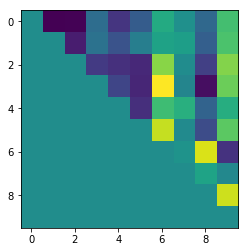

In [53]:
plt.figure()
plt.imshow(-mfCorr)

In [54]:
# - Map gini for income and assets

# - Construct data frames for income Gini
dfGini = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                       'gini_income': np.asarray(vfGini_Income_BS),
                       'gini_assets': np.asarray(vfGini_Assets_BS),
                       'gini_income_tax': np.asarray(vfGini_IncomeTax),
                       'gini_asset_tax': np.asarray(vfGini_AssetTax),
                       'PropGreenArea': vfPropGreenArea,
                       'PropWomenAtWork': vfPropWomenAtWork,
                       'PropSwiss': vfPropSwiss,
                       'PropApartments': vfPropApartments,
                       'NumRobberies': vnNumRobberies,
                       'NumDogsPer100': vfNumDogsPer100,
                       'PopPerHectare': vfPopPerHectare,
                      })

dfGini = pd.merge(dfGini, dfMapWVid_geoID,
                  on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapGini = pd.merge(gdfMap, dfGini,
                      left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

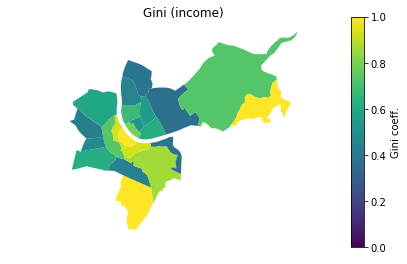

In [55]:
ax = gdfMapGini.plot(column = 'gini_income', vmin = 0.3, vmax = .6)
plt.axis('off')
plt.title('Gini (income)')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Gini coeff.')

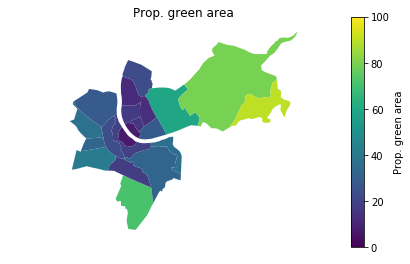

In [56]:
ax = gdfMapGini.plot(column = 'PropGreenArea', vmin = 0, vmax = 100)
plt.axis('off')
plt.title('Prop. green area')
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=100))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax).set_label('Prop. green area')

In [57]:
dfAssetsQ[find_WVQ(7)]

,wohnviertel_id,Wohnviertel,assetquintile_id,num_declarations,total_assets,total_asset_tax,marginal_tax_rate
30,7,Bruderholz,1,1004,70098,0,0.000000
31,7,Bruderholz,2,991,10188488,0,0.000000
32,7,Bruderholz,3,997,69200973,22069,0.000319
33,7,Bruderholz,4,997,312416913,803083,0.002571
34,7,Bruderholz,5,997,12169879848,89278854,0.007336


# Income and Asset distributions
One salient aspect of the data is the unequal distributions of assets compared with income, within and between Wohnvierteln. This is clearly reflected in the Gini for assets being very high, and higher than the Gini for income.

Let's compare the income and asset distributions visually.

In [58]:
# Functions to visually compare distributions of income vs assets 
def income_vs_assets(nQ):
    plt.scatter([1, 2, 3, 4, 5], dfIncomeQ[find_WVQ(nQ)].total_income / 1e9)
    plt.scatter([1, 2, 3, 4, 5], dfAssetsQ[find_WVQ(nQ)].total_assets / 1e9)
    plt.xlabel('Income / Assets quintile')
    plt.ylabel('Total income / total assets (B CHF)')
    plt.xticks([1, 2, 3, 4, 5], ['20%', '40%', '60%', '80%', '100%'])

def income_vs_assets_norm(nQ):
    vfIncome = np.asarray(dfIncomeQ[find_WVQ(nQ)].total_income)
    vfAssets = np.asarray(dfAssetsQ[find_WVQ(nQ)].total_assets)
    plt.scatter([1, 2, 3, 4, 5], vfIncome / vfIncome[-1])
    plt.scatter([1, 2, 3, 4, 5], vfAssets / vfAssets[-1])
    plt.xlabel('Income / Assets quintile')
    plt.ylabel('Prop. of total income / assets')
    plt.xticks([1, 2, 3, 4, 5], ['20%', '40%', '60%', '80%', '100%'])

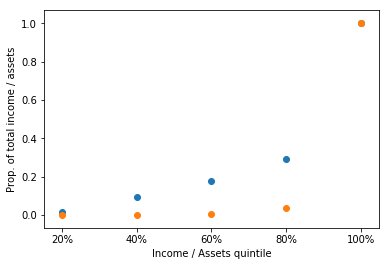

In [59]:
plt.figure()
income_vs_assets_norm(30)

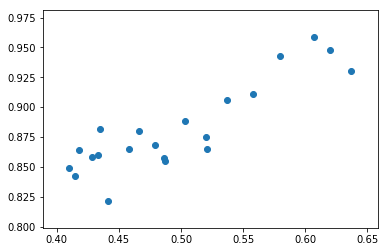

In [60]:
plt.figure()
plt.scatter(vfGini_Income_BS, vfGini_Assets_BS)

In [61]:
def assets_per_capita(nQ):
    return np.sum(dfAssetsQ[find_WVQ(nQ)].total_assets) / np.sum(dfAssetsQ[find_WVQ(nQ)].num_declarations)
    
assets_per_capita(3)
vfAssetsPerCap = [assets_per_capita(nQ) for nQ in vnWVIDs]

In [62]:
np.round(vfAssetsPerCap)

array([1015165., 1392666.,  435416.,  140160., 1033797.,  145346.,
       2519406.,  413563.,  229962.,  130113.,  131943.,  249077.,
        130164.,  296022.,  186072.,   76964.,  128623.,   59248.,
         68636.,  642705., 2359934.])

In [63]:
dfAssetsQ[find_WVQ(30)]

,wohnviertel_id,Wohnviertel,assetquintile_id,num_declarations,total_assets,total_asset_tax,marginal_tax_rate
100,30,Bettingen,1,126,16237,0,0.000000
101,30,Bettingen,2,126,1234094,0,0.000000
102,30,Bettingen,3,125,10834640,6090,0.000562
103,30,Bettingen,4,126,51162687,149605,0.002924
104,30,Bettingen,5,125,1418790612,9597244,0.006764


In [64]:
# - Construct data frames for assets
dfAssetsPerCap = pd.DataFrame({'wohnviertel_id': vnWVIDs,
                               'Assets_percap': vfAssetsPerCap,
                              })

dfAssetsPerCap = pd.merge(dfAssetsPerCap, dfMapWVid_geoID,
                          on = 'wohnviertel_id')

# - Merge with the map data 
gdfMapAPC = pd.merge(gdfMap, dfAssetsPerCap,
                      left_on = 'OBJECTID', right_on = 'geo_wohnviertel_id')

Text(0.5,1,'Assets per cap.')

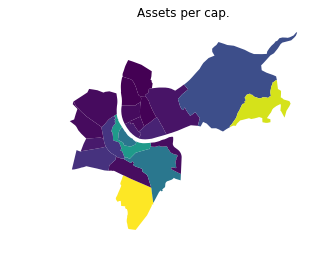

In [65]:
ax = gdfMapAPC.plot(column = 'Assets_percap')
plt.axis('off')
plt.title('Assets per cap.')


In [66]:
dfMapWVid_geoID
dfAssetsPerCap

,Assets_percap,wohnviertel_id,geo_wohnviertel_id,Wohnviertel
0,1.015165e+06,1,7,Altstadt Grossbasel
1,1.392666e+06,2,6,Vorstaedte
2,4.354163e+05,3,8,Am Ring
3,1.401603e+05,4,4,Breite
4,1.033797e+06,5,3,St. Alban
5,1.453460e+05,6,2,Gundeldingen
6,2.519406e+06,7,1,Bruderholz
7,4.135633e+05,8,5,Bachletten
8,2.299625e+05,9,9,Gotthelf
9,1.301127e+05,10,10,Iselin


In [67]:
dfSortedAssetsPerCap = dfAssetsPerCap.merge(dfMapWVid_geoID, on="wohnviertel_id").sort_values('Assets_percap')
dfSortedAssetsPerCap

,Assets_percap,wohnviertel_id,geo_wohnviertel_id_x,Wohnviertel_x,geo_wohnviertel_id_y,Wohnviertel_y
17,5.924808e+04,18,17,Klybeck,17,Klybeck
18,6.863598e+04,19,16,Kleinhueningen,16,Kleinhueningen
15,7.696407e+04,16,18,Rosental,18,Rosental
16,1.286225e+05,17,19,Matthaeus,19,Matthaeus
9,1.301127e+05,10,10,Iselin,10,Iselin
12,1.301640e+05,13,13,Clara,13,Clara
10,1.319428e+05,11,11,St. Johann,11,St. Johann
3,1.401603e+05,4,4,Breite,4,Breite
5,1.453460e+05,6,2,Gundeldingen,2,Gundeldingen
14,1.860717e+05,15,15,Hirzbrunnen,15,Hirzbrunnen


In [68]:
np.cumsum(dfSortedAssetsPerCap.Assets_percap)

17    5.924808e+04
18    1.278841e+05
15    2.048481e+05
16    3.334706e+05
9     4.635834e+05
12    5.937474e+05
10    7.256902e+05
3     8.658504e+05
5     1.011196e+06
14    1.197268e+06
8     1.427231e+06
11    1.676308e+06
13    1.972330e+06
7     2.385893e+06
2     2.821309e+06
19    3.464014e+06
0     4.479179e+06
4     5.512975e+06
1     6.905642e+06
20    9.265575e+06
6     1.178498e+07
Name: Assets_percap, dtype: float64

In [69]:
np.cumsum(dfSortedAssetsPerCap.Assets_percap[::-1])

6     2.519406e+06
20    4.879339e+06
1     6.272006e+06
4     7.305802e+06
0     8.320967e+06
19    8.963672e+06
2     9.399088e+06
7     9.812651e+06
13    1.010867e+07
11    1.035775e+07
8     1.058771e+07
14    1.077378e+07
5     1.091913e+07
3     1.105929e+07
10    1.119123e+07
12    1.132140e+07
9     1.145151e+07
16    1.158013e+07
15    1.165710e+07
18    1.172573e+07
17    1.178498e+07
Name: Assets_percap, dtype: float64

In [71]:
sps.pearsonr?

In [73]:
np.abs?